Using data from: https://fred.stlouisfed.org/series/MRTSSM448USN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

import fbprophet

# Load data

In [2]:
df = pd.read_csv('./data/RSCCASN.csv')

In [3]:
df['DATE'] = pd.to_datetime(df['DATE'], yearfirst=True)
df.rename(columns={'RSCCASN':'sales', 'DATE': 'date'}, inplace=True)
df.set_index('date', inplace=True)

In [4]:
df.head()

,sales
date,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


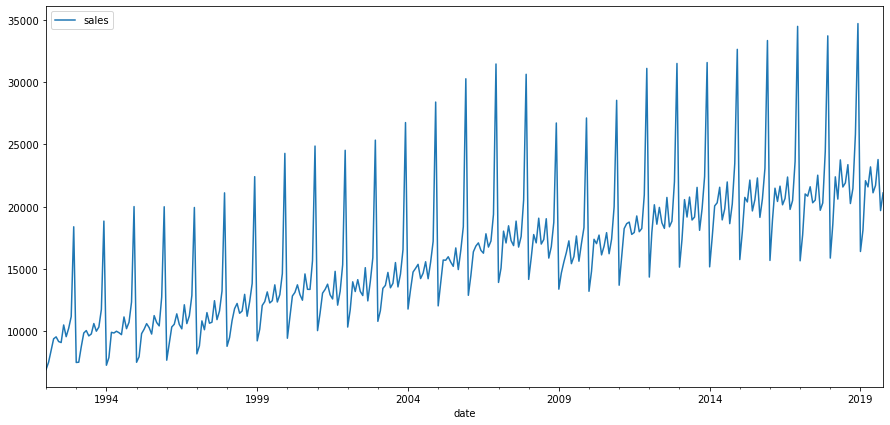

In [5]:
df.plot(figsize=(15, 7))
plt.show()

# Train & Test split

In [6]:
test_size = len(df) - 18 # define a 18-month test size

In [7]:
train = df.iloc[:test_size]
test = df.iloc[test_size:]

In [8]:
scaler = MinMaxScaler()

In [9]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

# Train and evaluate the model

In [10]:
length = 12  # using 12 months, predict the 13th
n_features = 1 # only 1 feature in the time series
generator = TimeseriesGenerator(scaled_train, scaled_train,
                                length=length, batch_size=1)

In [11]:
model = Sequential()

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [12]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

# create a validation generator - same as the trianing, but with the testing 18-month period
validation_generator = TimeseriesGenerator(scaled_test,
                                           scaled_test,
                                           length=length,
                                           batch_size=1)

model.fit(generator, epochs=50,
          validation_data=validation_generator,
          callbacks=[early_stop])

Epoch 1/50
304/304 [==============================] - 5s 16ms/step - loss: 0.0241 - val_loss: 0.0333
Epoch 2/50
304/304 [==============================] - 4s 15ms/step - loss: 0.0178 - val_loss: 0.0041
Epoch 3/50
304/304 [==============================] - 4s 14ms/step - loss: 0.0128 - val_loss: 0.0046
Epoch 4/50
304/304 [==============================] - 5s 15ms/step - loss: 0.0060 - val_loss: 0.0013
Epoch 5/50
304/304 [==============================] - 5s 15ms/step - loss: 0.0030 - val_loss: 8.3465e-04
Epoch 6/50
304/304 [==============================] - 5s 15ms/step - loss: 0.0039 - val_loss: 0.0025
Epoch 7/50
304/304 [==============================] - 5s 15ms/step - loss: 0.0027 - val_loss: 5.9765e-04
Epoch 8/50
304/304 [==============================] - 4s 15ms/step - loss: 0.0015 - val_loss: 9.1220e-04
Epoch 9/50
304/304 [==============================] - 4s 14ms/step - loss: 0.0012 - val_loss: 6.2083e-04
Epoch 10/50
304/304 [==============================] - 4s 15ms/step - loss:

In [13]:
model_perf = pd.DataFrame(model.history.history)
model_perf

,loss,val_loss
0,0.024131,0.033290
1,0.017843,0.004141
2,0.012756,0.004638
3,0.005985,0.001258
4,0.002979,0.000835
5,0.003928,0.002514
6,0.002732,0.000598
7,0.001487,0.000912
8,0.001151,0.000621
9,0.001303,0.000299


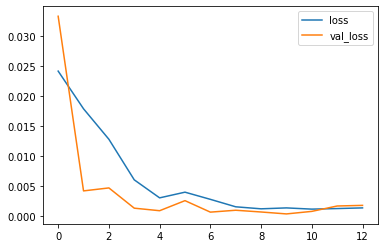

In [14]:
model_perf.plot()
plt.show()

In [15]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

## Compare predictions to actuals

<ipython-input-16-77c56970dc3c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred'] = true_predictions


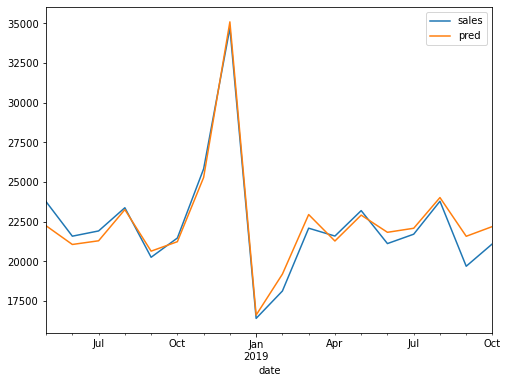

In [16]:
true_predictions = scaler.inverse_transform(test_predictions) # inverse scale to get actual values
test['pred'] = true_predictions
test.plot(figsize=(8,6))

In [17]:
metrics.mean_absolute_error(test['sales'], test['pred'])

630.0094577868778

In [18]:
np.sqrt(metrics.mean_squared_error(test['sales'], test['pred']))

787.2208013337914

# Retrain the model on the complete dataset

In [19]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)
length = 12 # Length of the output sequences (in number of timesteps)
complete_generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [20]:
model = Sequential()

model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.fit(complete_generator, epochs=6)

Epoch 1/6
322/322 [==============================] - 5s 15ms/step - loss: 0.0260
Epoch 2/6
322/322 [==============================] - 5s 15ms/step - loss: 0.0170
Epoch 3/6
322/322 [==============================] - 5s 15ms/step - loss: 0.0091
Epoch 4/6
322/322 [==============================] - 5s 15ms/step - loss: 0.0056
Epoch 5/6
322/322 [==============================] - 5s 15ms/step - loss: 0.0028
Epoch 6/6
322/322 [==============================] - 5s 15ms/step - loss: 0.0019


In [22]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    


In [23]:
forecast = full_scaler.inverse_transform(forecast)
forecast_index = pd.date_range(start='2019-11-01',periods=periods,freq='MS')

forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

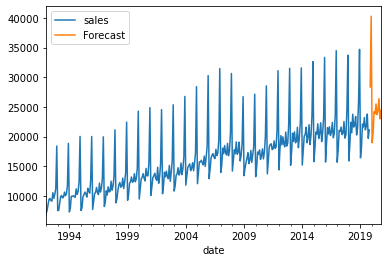

In [24]:
ax = df.plot()
forecast_df.plot(ax=ax)

(576.0, 611.0)

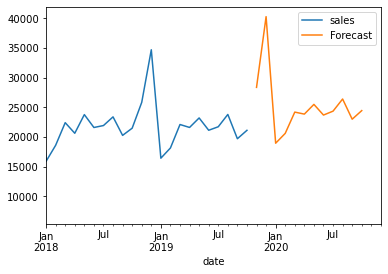

In [25]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')

# Using Prophet

In [26]:
proph = fbprophet.Prophet()

In [27]:
df_prophet = df.reset_index().rename(columns={'date':'ds', 'sales':'y'})

In [28]:
proph.fit(df_prophet)

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [29]:
df2_forecast = proph.make_future_dataframe(periods=10, freq='MS')

In [30]:
df2_forecast = proph.predict(df2_forecast)

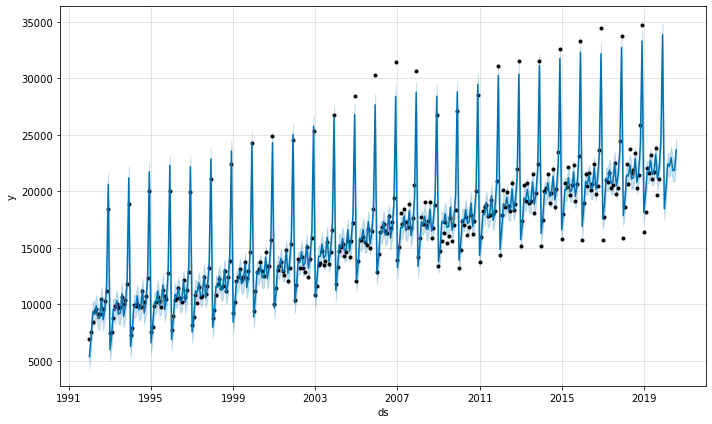

In [31]:
fig1 = proph.plot(df2_forecast)
# plt.xlim('2018-01-01','2020-12-01')

# Comparing the LSTM vs Prophet

(576.0, 611.0)

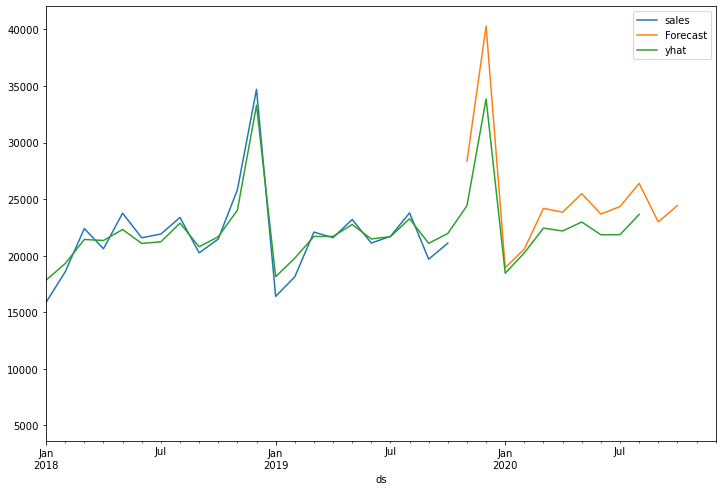

In [32]:
ax = df.plot(figsize=(12, 8))
forecast_df.plot(ax=ax)
df2_forecast.set_index('ds')[['yhat']].plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')